# Métodos de Reamostragem (Resampling Methods)

Prof. Daniel de Abreu Pereira Uhr

### Conteúdo
* Introdução
* Cross-Validation (Validação Cruzada)
  * The Validation Set Approach (A Abordagem do Conjunto de Validação)
  * Leave-One-Out Cross-Validation (Validação Cruzada Leave-One-Out)
  * k-Fold Cross-Validation
* The Bootstrap

### Referências

* [An Introduction to Statistical Learning](https://www.statlearning.com/) (ISL) by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani
  * Capítulo 5***
* [The Elements of Statistical Learning](https://hastie.su.domains/ElemStatLearn/) (ESL) by Trevor Hastie, Robert Tibshirani and Jerome Friedman : 
  * Capítulo 7

***Observações:*** *O material apresentado aqui é uma adaptação do material de aula do Prof. Daniel de Abreu Pereira Uhr, e não deve ser utilizado para fins comerciais. O material é disponibilizado para fins educacionais e de pesquisa, e não deve ser reproduzido sem a devida autorização do autor. Este material pode conter erros e imprecisões. O autor não se responsabiliza por quaisquer danos ou prejuízos decorrentes do uso deste material. O uso deste material é de responsabilidade exclusiva do usuário. Caso você encontre erros ou imprecisões neste material, por favor, entre em contato com o autor para que possam ser corrigidos. O autor agradece qualquer feedback ou sugestão de melhoria.*

### 1. Introdução

Os métodos de reamostragem envolvem a extração repetida de amostras de um conjunto de treinamento e o reajuste de um modelo de interesse em cada amostra para obter informações adicionais sobre o modelo ajustado.



Carregando os pacotes necessários


In [1]:
# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# Import
import pandas as pd
import numpy as np
import seaborn as sns
import time

from numpy.linalg import inv
from numpy.random import normal
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import resample

In [3]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [4]:
# Set global parameters
%matplotlib inline
plt.style.use('seaborn-v0_8-white')
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

### 2. Cross-Validation (Validação Cruzada)

A validação cruzada pode ser usada para ***estimar o erro de teste associado a um determinado método de aprendizagem estatística***, a fim de avaliar seu desempenho ou selecionar o nível apropriado de flexibilidade. O processo de avaliação do desempenho de um modelo é conhecido como avaliação de modelo, enquanto o processo de seleção do nível adequado de flexibilidade para um modelo é conhecido como seleção de modelo.

Vamos usar o conjunto de dados `Auto.csv`.

In [24]:
df1 = pd.read_csv("https://github.com/Daniel-Uhr/data/raw/main/Auto.csv")
df1

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
387,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl
388,44.0,4,97.0,52,2130,24.6,82,2,vw pickup
389,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage
390,28.0,4,120.0,79,2625,18.6,82,1,ford ranger


### 2.1. The Validation Set Approach (A Abordagem do Conjunto de Validação)

Suponha que gostaríamos de estimar o erro de teste associado ao ajuste de um método específico de aprendizagem estatística em um conjunto de observações. *The Validation Set Approach* é uma estratégia muito simples para essa tarefa. Ela envolve ***dividir aleatoriamente o conjunto de observações disponível (dados internos / "Internal Data")em duas partes***:

* um conjunto de treinamento (Training Data) e
* um conjunto de validação ou conjunto de retenção (Test Data).

O ***modelo é ajustado ao conjunto de treinamento***, e **o modelo ajustado é usado para prever as respostas para as observações no conjunto de validação**. 

***A taxa de erro do conjunto de validação resultante é normalmente avaliada por meio de MSE, no caso de uma resposta quantitativa, e fornece uma estimativa da taxa de erro do teste***. 

Vejamos na imagem:

<div style="text-align:center;">
    <img src="images\cross-validation.png"  alt="Imagem" style="width: 450px;"/>
</div>


Na parte superior temos o conjunto de dados original (Internal Data - em cinza) e a porção de dados futura (Unseen Data - não observada). Na parte inferior, temos o conjunto de treinamento e o conjunto de validação. O conjunto de treinamento é usado para ajustar o modelo, enquanto o conjunto de validação é usado para avaliar o desempenho do modelo ajustado a fim de ser utilizado no conjunto de dados futuro (não observado).

***Como decidir o tamanho do conjunto de treinamento e do conjunto de validação? E, quais partes do conjunto de dados devem ser usadas para o treinamento e a validação?***

No exemplo a seguir, calcularemos o polinômio de diferentes ordens (de um a dez). Dividiremos os dados 50-50 entre os conjuntos de treinamento e teste. E calcularemos o erro quadrático médio (MSE) para cada um dos modelos ajustados.

In [25]:
# Função de Cross-Validação para polinomios

def cv_poly(X, y, p_order, r_states, t_prop):
    start = time.time()
    
    # Init scores
    scores = np.zeros((p_order.size,r_states.size))
    
    # Generar 10 divisões aleatórias no conjunto de dados
    for j in r_states:
        
        # Dividir a amostra entre treinamento e teste
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_prop, random_state=j)
        
            
        # Para cada polinomio de grau i
        for i in p_order:

            # Gerar polinomios
            X_train_poly = PolynomialFeatures(i+1).fit_transform(X_train)
            X_test_poly = PolynomialFeatures(i+1).fit_transform(X_test)

            # Ajustar o modelo
            ols = LinearRegression().fit(X_train_poly, y_train)
            pred = ols.predict(X_test_poly)
            scores[i,j]= mean_squared_error(y_test, pred)
    print('Time elapsed: %.4f seconds' % (time.time()-start))
    return scores

Vamos fazer uma análise visual da variabilidade do erro quadrático médio (MSE) na validação cruzada de modelos polinomiais com diferentes graus e diferentes divisões aleatórias dos dados

In [ ]:
# Iniciar
t_prop = 0.5                # Proporção de teste: 50%
p_order = np.arange(10)     # Graus de polinômios de 1 a 10
r_states = np.arange(10)    # 10 random states para gerar 10 splits diferentes

# selecionar X,y / Variável preditora a horsepower e como resposta o mpg (miles per gallon).
X = df1.horsepower.values.reshape(-1,1)
y = df1.mpg.ravel()

# Compute scores
cv_scores = cv_poly(X, y, p_order, r_states, t_prop)

Time elapsed: 0.3325 seconds


In [29]:
cv_scores.shape

(10, 10)

O `cv_poly` calculou o MSE para cada grau de polinômio, repetindo com 10 divisões aleatórias dos dados.
Resultado: uma matriz cv_scores de shape (10,10).
* Cada linha → um grau de polinômio.
* Cada coluna → uma divisão aleatória (random state).

In [ ]:
# Figure 5.2
def make_figure_5_2():
    
    # Init
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,6))
    fig.suptitle('Figure 5.2')

    # Subplot da esquerda
    # Mostra o erro para cada grau de polinômio, mas apenas na primeira divisão aleatória (random state 0).
    # Serve para visualizar como o MSE varia com a complexidade do modelo, mas numa única amostra de treino-teste.
    ax1.plot(p_order+1,cv_scores[:,0], '-o')
    ax1.set_title('Random split of the data set')

    # Subplot da direita:
    # Plota todos os splits ao mesmo tempo.
    # Cada linha colorida representa um split diferente → mostra a variabilidade dos resultados.
    # Revela como o erro médio pode variar significativamente dependendo da partição dos dados.
    ax2.plot(p_order+1,cv_scores)
    ax2.set_title('10 random splits of the data set')

    for ax in fig.axes:
        ax.set_ylabel('Mean Squared Error')
        ax.set_ylim(15,30)
        ax.set_xlabel('Degree of Polynomial')
        ax.set_xlim(0.5,10.5)
        ax.set_xticks(range(2,11,2));

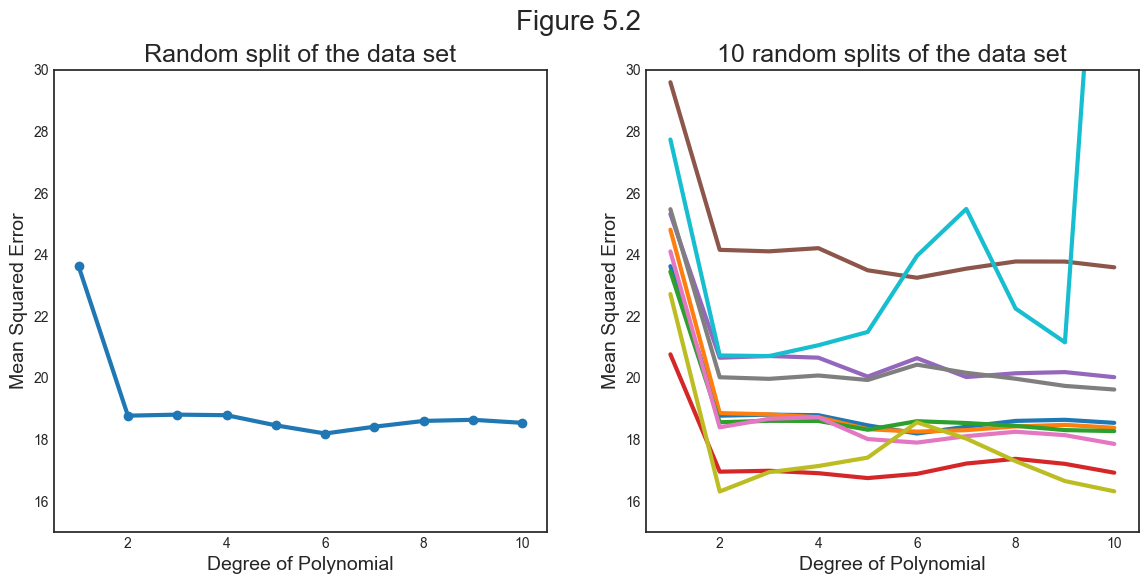

In [28]:
make_figure_5_2()

Esta figura ilustra uma das principais desvantagens da abordagem de validação simples: a estimativa da taxa de erro pode ser altamente variável, dependendo exatamente de quais observações são alocadas nos conjuntos de treinamento e de validação.

Além disso, a validação simples possui uma segunda limitação importante: apenas um subconjunto das observações — aquelas incluídas no conjunto de treinamento, e não no conjunto de validação — é utilizado para ajustar o modelo. Como os métodos estatísticos tendem a apresentar um desempenho inferior quando treinados com um número reduzido de observações, a taxa de erro estimada no conjunto de validação pode superestimar a verdadeira taxa de erro que seria obtida se o modelo fosse ajustado utilizando o conjunto completo de dados.

Em resumo:
* Gráfico da esquerda: mostra como uma análise isolada pode ser enganosa.
* Gráfico da direita: evidencia a variabilidade.

Há necessidade de métodos mais robustos de avaliação de desempenho.



### 2.2. Leave-One-Out Cross-Validation (Validação Cruzada Leave-One-Out)

A validação cruzada leave-one-out (LOOCV) tenta resolver as desvantagens desse método.

Assim como a abordagem do conjunto de validação, o LOOCV envolve a divisão do conjunto de observações em duas partes. No entanto, em vez de criar dois subconjuntos de tamanho comparável, uma única observação
é usado para o conjunto de validação e o restante $n-1$ observações compõem o conjunto de treinamento. O método de aprendizagem estatística é ajustado no $n-1$ observações de treinamento e o MSE é calculado usando a observação excluída $i$. O procedimento é repetido $n$ vezes, para $i=1,2,\ldots,n$.

A estimativa do LOOCV para o teste MSE é a média destes $n$ estimativas de erro de teste:

$$ \mathrm{CV} {(n)}=\frac{1}{n} \sum {i=1}^{n} \mathrm{MSE}_{i} $$

O LOOCV tem algumas vantagens importantes em relação à abordagem do conjunto de validação.

Primeiro, tem muito menos viés. No LOOCV, ajustamos repetidamente o método de aprendizagem estatística usando conjuntos de treinamento que contêm $n-1$ observações, quase tantas quanto as de todo o conjunto de dados. No entanto, isso também significa que o LOOCV é computacionalmente mais intenso.

Em segundo lugar, em contraste com a abordagem de validação que produzirá resultados diferentes quando aplicada repetidamente devido à aleatoriedade nas divisões do conjunto de treinamento/validação, executar LOOCV várias vezes sempre produzirá os mesmos resultados: não há aleatoriedade nas divisões do conjunto de treinamento/validação.

In [10]:
# LeaveOneOut CV function for polynomials
def loo_cv_poly(X, y, p_order):
    start = time.time()
    
    # Init
    loo = LeaveOneOut().get_n_splits(y)
    loo_scores = np.zeros((p_order.size,1))
    
    # For every polynomial degree
    for i in p_order:
        # Generate polynomial
        X_poly = PolynomialFeatures(i+1).fit_transform(X)

        # Get score
        loo_scores[i] = cross_val_score(LinearRegression(), X_poly, y, cv=loo, scoring='neg_mean_squared_error').mean()
        
    print('Time elapsed: %.4f seconds' % (time.time()-start))
    return loo_scores

Vamos comparar a abordagem do conjunto de validação com o LOO em termos de tempo computacional.

In [11]:
# Validation set approach
cv_scores = cv_poly(X, y, p_order, r_states, t_prop)
    
# Leave One Out CV
loo_scores = loo_cv_poly(X, y, p_order)

Time elapsed: 0.3325 seconds
Time elapsed: 6.0270 seconds


Como esperado, o LOOCV é muito mais intensivo computacionalmente, mesmo considerando o fato de que repetimos cada abordagem do conjunto de validação 10 vezes.

Vamos agora compará-los em termos de precisão na minimização do MSE.

In [12]:
# Make new figure 1
def make_new_figure_1():

    # Init
    fig, ax = plt.subplots(1,1, figsize=(7,6))

    # Left plot
    ax.plot(p_order+1, np.array(loo_scores)*-1, '-o', label='LOOCV')
    ax.plot(p_order+1, np.mean(cv_scores, axis=1), '-o', c='orange', label='Standard CV')
    ax.set_ylabel('Mean Squared Error'); ax.set_xlabel('Degree of Polynomial');
    ax.set_ylim(15,30); ax.set_xlim(0.5,10.5);
    ax.set_xticks(range(2,11,2));
    ax.legend();

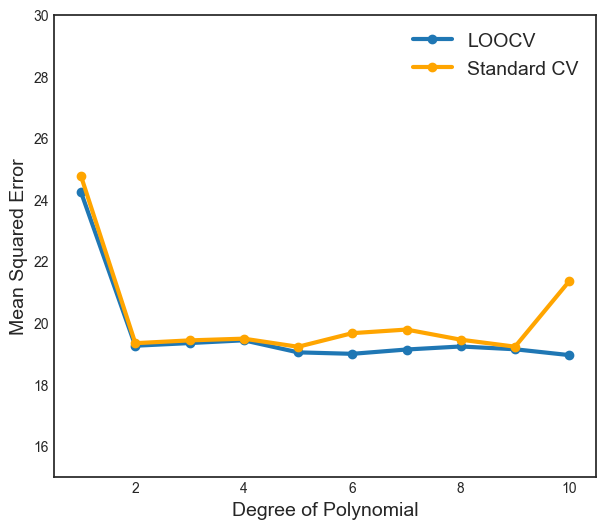

In [13]:
make_new_figure_1()

Com a regressão linear ou polinomial de mínimos quadrados, um atalho incrível torna o custo do LOOCV igual ao de um ajuste de modelo único! A seguinte fórmula se aplica:

$$ \mathrm{CV}{(n)}=\frac{1}{n} \sum{i=1}^{n}\left(\frac{y_{i}-\hat{y}{i}}{1-h{i}}\right)^{2} $$

onde $\hat{y} {i}$ é o $i^{th}$ valor ajustado do ajuste original dos mínimos quadrados e $h_{i}$ é a alavanca da observação $i$.

### k-Fold Cross-Validation

Uma alternativa ao LOOCV é o CV k-fold. Essa abordagem envolve as seguintes etapas:

* Dividindo aleatoriamente o conjunto de observações em $k$ grupos, ou dobras, de tamanho aproximadamente igual.
* A primeira dobra é tratada como um conjunto de validação e o método é ajustado no restante $k-1$ dobras.
* O erro quadrático médio, MSE1, é então calculado nas observações na dobra mantida.
* Os passos (1)-(3) são repetidos $k$ vezes; cada vez, um grupo diferente de observações é tratado como um conjunto de validação.


A estimativa do CV k-fold é calculada pela média desses valores

$$ \mathrm{CV} {(k)}=\frac{1}{k} \sum {i=1}^{k} \mathrm{MSE}_{i} $$

LOOCV é um caso especial de CV k-fold em que $k$ é definido como igual $n$. Na prática, normalmente realiza-se o CV k-fold usando $k=5$ ou $k=10$.

A vantagem mais óbvia é computacional. O LOOCV requer o ajuste do método de aprendizagem estatística
vezes, enquanto o CV k-fold requer apenas $k$ divisões.

In [14]:
# 10fold CV function for polynomials
def k10_cv_poly(X, y, p_order, r_states, folds):
    start = time.time()
    
    # Init
    k10_scores = np.zeros((p_order.size,r_states.size))

    # Generate 10 random splits of the dataset
    for j in r_states:

        # For every polynomial degree
        for i in p_order:

            # Generate polynomial
            X_poly = PolynomialFeatures(i+1).fit_transform(X)

            # Split sample in train and test
            kf10 = KFold(n_splits=folds, shuffle=True, random_state=j)
            k10_scores[i,j] = cross_val_score(LinearRegression(), X_poly, y, cv=kf10, 
                                               scoring='neg_mean_squared_error').mean()  
    
    print('Time elapsed: %.4f seconds' % (time.time()-start))
    return k10_scores

Vamos agora comparar a validação cruzada de 10 vezes com LOO em termos de tempo computacional.

In [15]:
# Leave One Out CV
loo_scores = loo_cv_poly(X, y, p_order)
    
# 10-fold CV
folds = 10
k10_scores = k10_cv_poly(X, y, p_order, r_states, folds)

Time elapsed: 6.8961 seconds
Time elapsed: 1.8442 seconds


De fato, vemos que a abordagem LOOCV é computacionalmente mais intensiva, mesmo considerando o fato de que repetimos cada validação cruzada de 10 vezes 10 vezes.

Agora podemos comparar todos os métodos em termos de precisão.

In [16]:
# Figure 5.4
def make_figure_5_4():

    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(17,5))
    fig.suptitle('Figure 5.4')

    # Left plot
    ax1.plot(p_order+1, np.array(loo_scores)*-1, '-o')
    ax1.set_title('LOOCV', fontsize=12)

    # Center plot
    ax2.plot(p_order+1,k10_scores*-1)
    ax2.set_title('10-fold CV', fontsize=12)

    # Right plot
    ax3.plot(p_order+1, np.array(loo_scores)*-1, '-o', label='LOOCV')
    ax3.plot(p_order+1, np.mean(cv_scores, axis=1), label='Standard CV')
    ax3.plot(p_order+1,np.mean(k10_scores,axis=1)*-1, label='10-fold CV')
    ax3.set_title('Comparison', fontsize=12);
    ax3.legend();

    for ax in fig.axes:
        ax.set_ylabel('Mean Squared Error')
        ax.set_ylim(15,30)
        ax.set_xlabel('Degree of Polynomial')
        ax.set_xlim(0.5,10.5)
        ax.set_xticks(range(2,11,2));

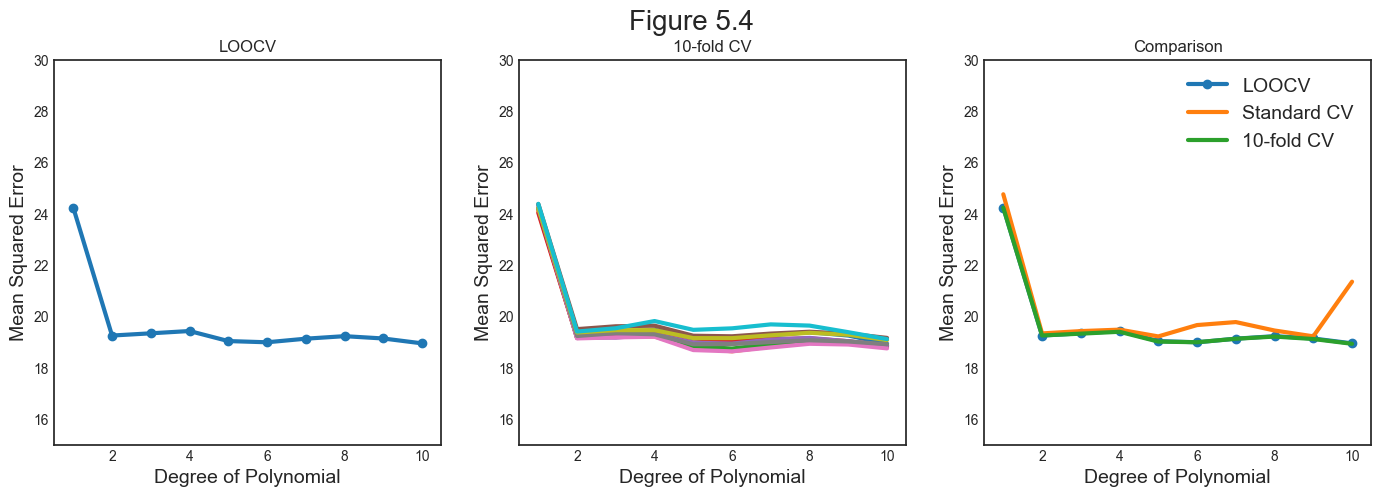

In [17]:
make_figure_5_4()

A validação cruzada de 10 vezes produz um MSE muito semelhante em relação ao LOOCV, mas com tempo computacional consideravelmente menor.

### O Bootstrap

O bootstrap é uma ferramenta estatística amplamente aplicável e extremamente poderosa que pode ser usada para quantificar a incerteza associada a um determinado estimador ou método de aprendizagem estatística. No caso específico da regressão linear, isso não é particularmente útil, pois existe uma fórmula para os erros-padrão. No entanto, existem muitos modelos (quase todos, na verdade) para os quais não existe uma solução fechada para a variância do estimador.

Em princípio, gostaríamos de extrair amostras independentes do verdadeiro processo de geração de dados e avaliar a incerteza de um estimador comparando seus valores entre as diferentes amostras. No entanto, isso é claramente inviável, visto que não conhecemos o verdadeiro processo de geração de dados.

Com o bootstrap, em vez de obter repetidamente conjuntos de dados independentes da população, obtemos conjuntos de dados distintos por meio de amostragem repetida de observações do conjunto de dados original. O poder do bootstrap reside no fato de que ele pode ser facilmente aplicado a uma ampla gama de métodos de aprendizagem estatística, incluindo alguns para os quais uma medida de variabilidade é difícil de obter e não é gerada automaticamente por softwares estatísticos.

Agora, vamos avaliar sua utilidade por meio de simulação. Considere o seguinte modelo:

$$ y_{i}=\beta_{0}x_{i}+\epsilon_{i} $$

onde $\beta_{0}=0.6$ e $\epsilon_{i} \sim N(0,1)$. Vamos agora avaliar a variância do estimador MCO
com a fórmula padrão, simulando diferentes amostras e com bootstrap.

In [18]:
# Set seed
np.random.seed(1)

# Init
simulations = 1000
N = 1000
beta_0 = 0.6
beta_sim = np.zeros((simulations,1))

# Generate X
X = normal(0,3,N).reshape(-1,1)

# Loop over simulations
for i in range(simulations):
    
    # Generate y
    e = normal(0,1,N).reshape(-1,1)
    y = beta_0*X + e
    
    # Estimate beta OLS
    beta_sim[i] = inv(X.T @ X) @ X.T @ y

In [19]:
# Init Bootstrap
beta_boot = np.zeros((simulations,1))

# Loop over simulations
for i in range(simulations):
    
    # Sample y
    X_sample, y_sample = resample(X, y, random_state=i)
    
    # Estimate beta OLS
    beta_boot[i] = inv(X_sample.T @ X_sample) @ X_sample.T @ y_sample

Podemos primeiro comparar as médias.

In [20]:
# Print means
print('True value      : %.4f' % beta_0)
print('Mean Simulations: %.4f' % np.mean(beta_sim))
print('Mean One Sample : %.4f' % beta_sim[-1])
print('Mean Boostrap   : %.4f' % np.mean(beta_boot))

True value      : 0.6000
Mean Simulations: 0.6003
Mean One Sample : 0.5815
Mean Boostrap   : 0.5816


A média do estimador bootstrap está bastante equivocada. Mas este não é o seu propósito real: ele foi projetado para avaliar a incerteza de um estimador, não o seu valor.

Agora comparamos as variâncias.

In [21]:
# Print variances
print('True std       : %.6f' % np.sqrt(inv(X.T @ X)))
print('Std Simulations: %.6f' % np.std(beta_sim))
print('Std One Sample : %.6f' % np.sqrt(inv(X.T @ X) * np.var(y - beta_sim[-1]*X)))
print('Std Boostrap   : %.6f' % np.std(beta_boot))

True std       : 0.010737
Std Simulations: 0.010830
Std One Sample : 0.010536
Std Boostrap   : 0.010812


O Bootstrap chega tão perto do desvio padrão real do estimador quanto a simulação com o processo real de geração de dados. Impressionante!

Agora podemos fazer uma inspeção visual.

In [22]:
# Figure 5.10
def make_figure_5_10():

    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(14,6))
    fig.suptitle('Figure 5.10')

    # Left plot
    ax1.hist(beta_sim, bins=10, edgecolor='black');
    ax1.axvline(x=beta_0, color='r', label='beta_0')
    ax1.set_xlabel('beta simulated');

    # Center plot
    ax2.hist(beta_boot, bins=10, color='orange', edgecolor='black');
    ax2.axvline(x=beta_0, color='r', label='beta_0')
    ax2.set_xlabel('beta bootstrap');

    # Right plot
    df_bootstrap = pd.DataFrame({'simulated': beta_sim.ravel(), 'bootstrap':beta_boot.ravel()}, 
                                index=range(simulations))
    ax3 = sns.boxplot(data=df_bootstrap, width=0.5, linewidth=2);
    ax3.axhline(y=beta_0, color='r', label='beta_0');

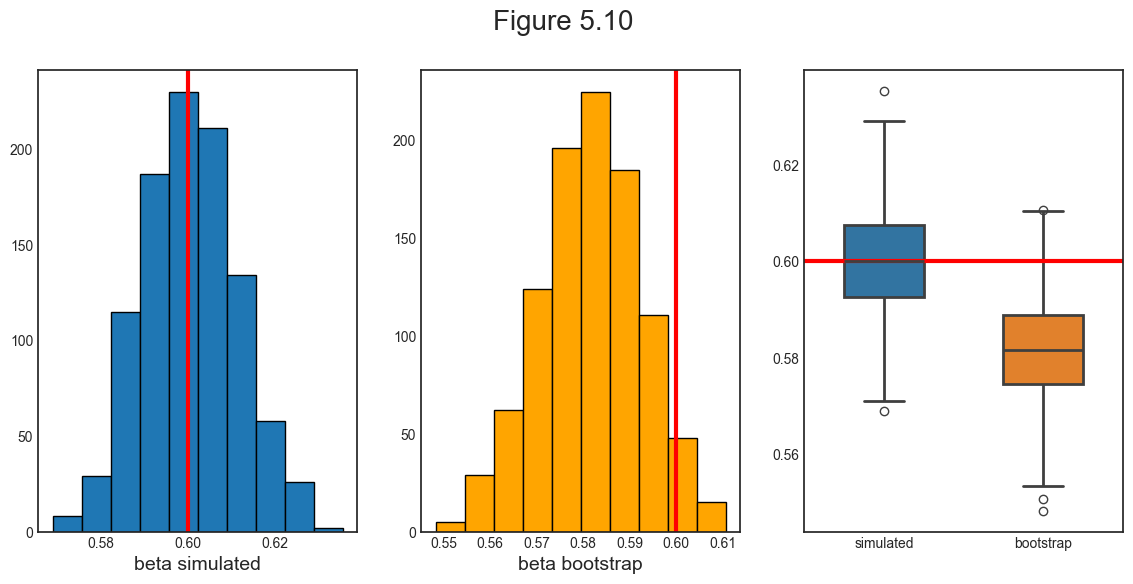

In [23]:
make_figure_5_10()

Como podemos ver, o bootstrap é uma ferramenta poderosa para avaliar a incerteza de um estimador.